In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt
colors = sns.color_palette()
%matplotlib inline

In [3]:
data_path = '/disk/ru'
streams = pd.read_json(os.path.join(data_path, 'streams'), lines=True)
streams['timestamp'] = pd.to_datetime(streams['timestamp'], format='%Y-%m-%d %H:%M:%S')
streams.sort_values(by=['timestamp'], inplace=True)
streams.reset_index(inplace=True, drop=True)
streams['delta'] = streams.groupby(['user_id'])['timestamp'].diff().dt.total_seconds()

streams.head()

,device_type,length,os,timestamp,track_id,user_id,delta
0,desktop,254,Linux,2017-09-09,2318538f5412b3e87cf335fb667c0e7f121ae830,bab3607bf601e7e681012f206b62b4b39ee7023c,NaN
1,mobile,179,iOS,2017-09-09,dc1dd219d560a964281d777ad34a62af288a1de8,2622b170e9ddcb7d05946e914ad6fe61cee6ea63,NaN
2,mobile,242,Android,2017-09-09,d6aa6ac360c555ef96830404a0b66cc2a4d6fb8d,637d4c31a14e65cf77a6bd75a2aa605e8655b244,NaN
3,mobile,214,iOS,2017-09-09,c0dd8f4afbd640483b2746bc7287a52383e63b72,885085495b80cb431f149b3d82fb4bcc44ea7469,NaN
4,mobile,249,Android,2017-09-09,212eebd1e92303a5e0c43141561a724d3b47b549,5e94bc2ccd18805ba6b1747cc5d3260020425b00,NaN


# Automated detect outlier
* outlier: number of release in a period (15mins) is beyond 1 standard deviation  
* sliding window size: 1 day (re-caculate std 1 day and It can be defined by clustering in future)
* outlier might come from botnet

In [4]:
# Find potentially outlier
# Get timestamp of outlier
time_release = streams.groupby('timestamp').size()
outlier = time_release[time_release.diff()/time_release > (time_release.diff()/time_release).std()].index
outlier.tolist()

[Timestamp('2017-09-09 02:00:00'),
 Timestamp('2017-09-09 04:15:00'),
 Timestamp('2017-09-09 05:00:00'),
 Timestamp('2017-09-09 08:00:00'),
 Timestamp('2017-09-09 11:00:00'),
 Timestamp('2017-09-09 14:00:00'),
 Timestamp('2017-09-09 17:00:00'),
 Timestamp('2017-09-09 20:00:00'),
 Timestamp('2017-09-09 23:00:00')]

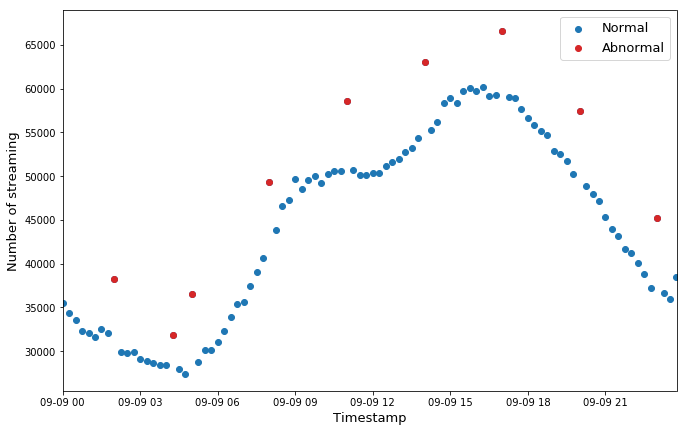

In [5]:
plt.figure(figsize=(11, 7))
time_group = streams.groupby(['timestamp']).size()
plt.scatter(x=time_group.index, y=time_group.values, color=colors[0], label='Normal')
plt.scatter(x=time_group.loc[outlier].index, y=time_group.loc[outlier].values, color=colors[3], label='Abnormal')
plt.xlim(min(time_group.index), max(time_group.index))
plt.xlabel('Timestamp', size=13)
plt.ylabel('Number of streaming', size=13)
plt.legend(prop={'size': 13})

plt.show()

## Time interval of every release

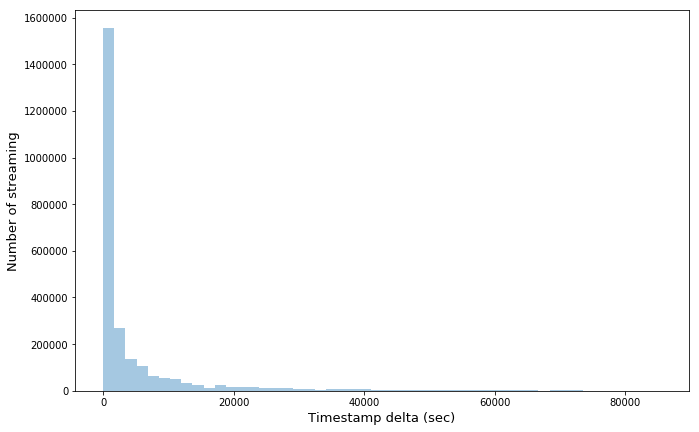

In [6]:
# Plot delta distribution
plt.figure(figsize=(11, 7))
sns.distplot(streams['delta'].dropna(), kde=False)
plt.xlabel('Timestamp delta (sec)', size=13)
plt.ylabel('Number of streaming', size=13)
plt.show()

## Three kinds of user
1. Normal user: no fix actions
2. Type I potential fraud: release huge number of tracks at a time
3. Type II potentially fraud: release huge number of tracks after a long time

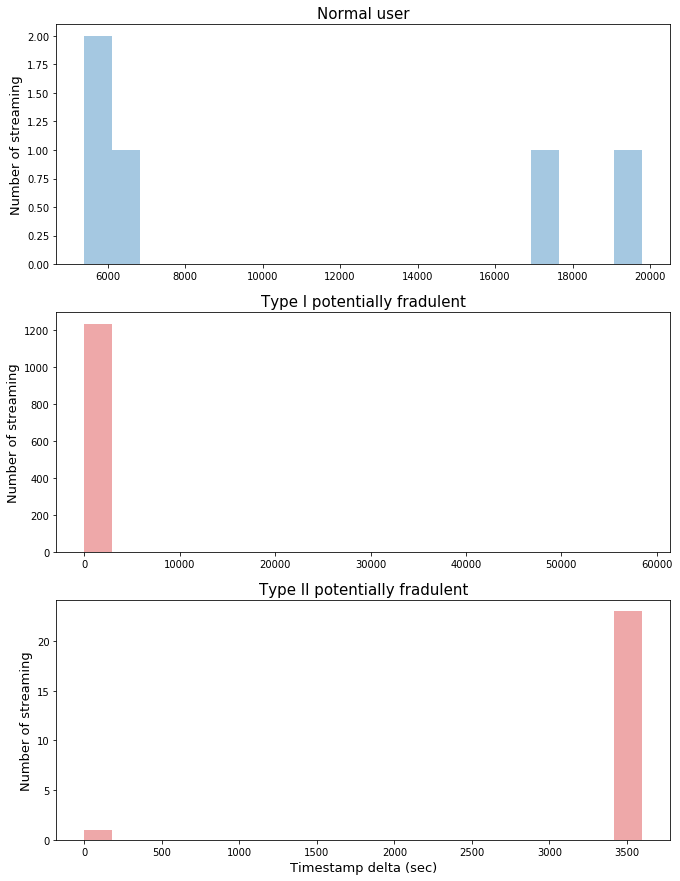

In [7]:
# plot frequency & count of release by a user
fig, axes = plt.subplots(nrows=3, figsize=(11, 15))
plt.subplot(3,1,1)
sns.distplot(streams['delta'].loc[streams['user_id']=='5b6d51824857416e5ae15792abd0103fd91618f1'].dropna(), 
             kde=False, bins=20)
plt.title('Normal user', fontsize=15)
plt.xlabel('', size=13)
plt.ylabel('Number of streaming', size=13)

plt.subplot(3,1,2)
sns.distplot(streams['delta'].loc[streams['user_id']=='c41f7f98ec5c0fdd81c23f2a43ad3d6e9b85cade'].dropna(), 
             kde=False, bins=20, color=colors[3])
plt.title('Type I potentially fraud', fontsize=15)
plt.xlabel('', size=13)
plt.ylabel('Number of streaming', size=13)

plt.subplot(3,1,3)
sns.distplot(np.append(streams['delta'].loc[streams['user_id']=='58d02c067e05aaa67404d3b6cb50233604b48b0f'].dropna().values, 0), 
             kde=False, bins=20, color=colors[3])
plt.title('Type II potentially fraud', fontsize=15)
plt.xlabel('Timestamp delta (sec)', size=13)
plt.ylabel('Number of streaming', size=13)

plt.show()

In [23]:
index = pd.date_range('2017-09-09 00:00:00', '2017-09-09 23:45:00', freq='15min')
data = pd.Series(0, index=index, name='tmp')
data = pd.concat([data, 
                  streams['timestamp'].loc[streams['user_id']=='5b6d51824857416e5ae15792abd0103fd91618f1'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='745cdb4f943954c7cf4bcbe588731b3af4548950'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='aad4e439093860edfbe9b3dc8c68963a712b37b0'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='d31bd3a4461ed83828f18ae59537fd6264a5eec0'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='58d02c067e05aaa67404d3b6cb50233604b48b0f'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='b6d1cb74cc340fc889756289296db845323e0b46'].value_counts(), 
                 ], axis=1)
data.drop(['tmp'], axis=1, inplace=True)
data.columns = ['normal_user_1', 'normal_user_2', 'normal_user_3', 
                'abnormal_user_1', 'abnormal_user_2', 'abnormal_user_3']

# Abnormal Behavior Define 1: Cyclic
(the potentail botnet behavior)  
## Rules :  delta not equal to 900   and have same delta  

normal user behavior is rather random  
abnormal user behavior is rather fixed  
a. release tracks many time in same period  
b. release tracks in exactly same interval  
c. keep release tracks all the time  

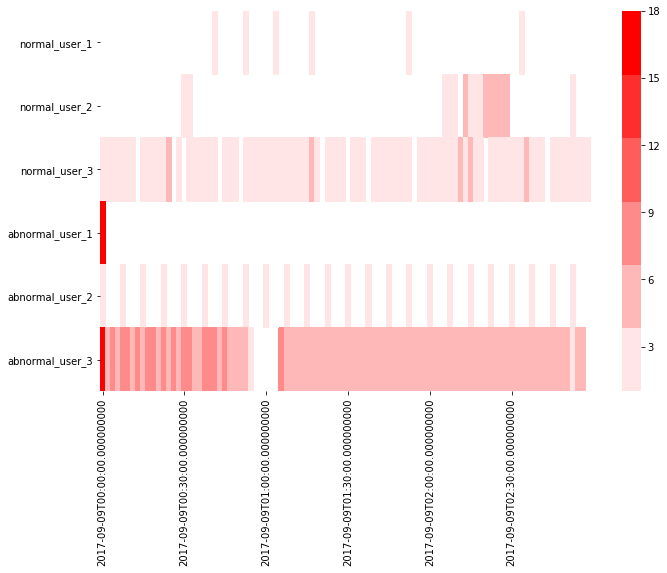

In [9]:
cmap = sns.light_palette("red")

plt.figure(figsize=(11, 7))
sns.heatmap(data.T, cmap=cmap)
plt.locator_params(axis='x', nbins=6)
plt.show()

## track legth & number of release

In [57]:
track_dist = streams.groupby(['track_id'])['length'].agg({'time': len, 'mean_len': np.mean})

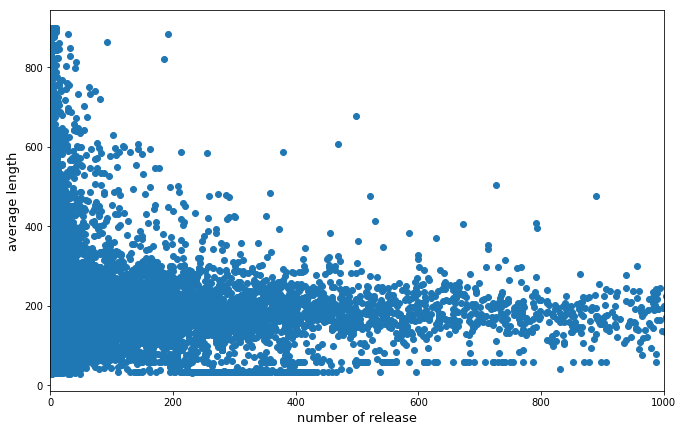

In [20]:
plt.figure(figsize=(11, 7))
plt.scatter(x=track_dist['time'], y=track_dist['mean_len'], color=colors[0])
plt.xlabel('number of release', size=13)
plt.ylabel('average length', size=13)
plt.xlim((0, 1000))
plt.show()

In [12]:
# User mapping track
user_track = streams.groupby('user_id')['track_id'].nunique()

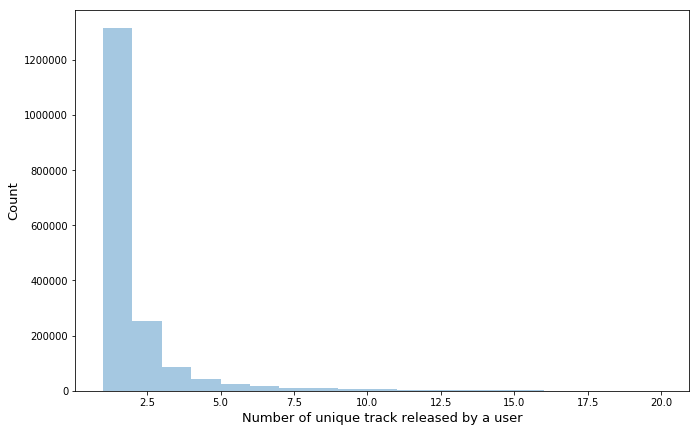

In [61]:
plt.figure(figsize=(11, 7))
sns.distplot(user_track.loc[user_track<=20], kde=False, bins=19)
plt.xlabel('Number of unique track released by a user', size=13)
plt.ylabel('Count', size=13)
plt.show()

# Abnomal Behavior 2:  release of same track 
## Rules :  ueser release same track exceed 3 times in same period 
describe: a user release same track too many times in same period  
abnormal define: less than 1% of the track released over 3 times in same period by same user

In [26]:
data = streams.groupby(['user_id', 'timestamp'])['track_id'].value_counts()
data = data.sort_values(ascending=False)

In [27]:
data.head()

user_id                                   timestamp            track_id                                
e5ff4e70540b569dca828c0d629c2c3eadf7a221  2017-09-09 01:45:00  1eb503ca5d996e140e3b6bf1ab9b16b9c8847857    1065
bc1e0f79a38a3d8262bb87361ed6b5c01631c774  2017-09-09 10:45:00  483a84f2e613c2faef7e859d7c58dbf231669d38     400
                                          2017-09-09 22:00:00  483a84f2e613c2faef7e859d7c58dbf231669d38     400
d75d2d15416af25e4c7dda1ae7fdcfd56cc98023  2017-09-09 17:15:00  be7cd84e8b175933f5b86276b429d87d414b5f4a     357
89acdddf6f62acfeb3ea509e2b8a8a6825f58f06  2017-09-09 04:15:00  9b35133f3f66921aa0ea2f11526b2a4f8c59e9d0     331
Name: track_id, dtype: int64

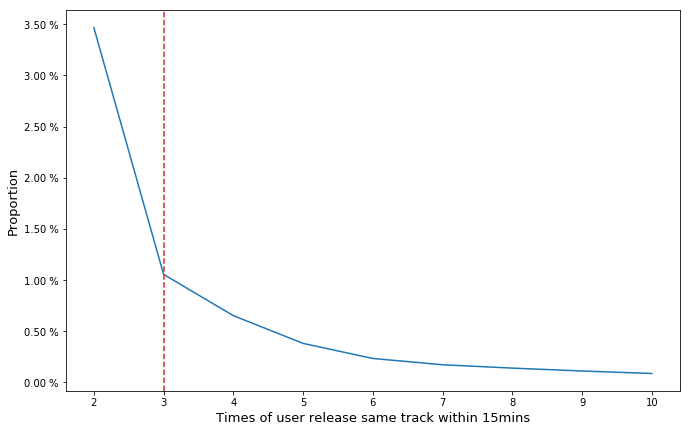

In [54]:
from matplotlib.ticker import FuncFormatter

def dis_percent(x, pos):
    return '%1.2f %%' %(x * 100)

prop = len(data)
x = np.arange(2, 11, 1)
y = [len(data.loc[data>=i])/prop for i in x]


fig, ax = plt.subplots(figsize=(11, 7))
formatter = FuncFormatter(dis_percent)
ax.yaxis.set_major_formatter(formatter)
plt.plot(x, y)
plt.axvline(x=3, color=colors[3], linestyle='dashed')
plt.xlabel('Times of user release same track within 15mins', fontsize=13)
plt.ylabel('Proportion', fontsize=13)

plt.show()

In [59]:
fraud = data.loc[data>3]
fraud.name = 'cnt'
fraud = fraud.reset_index()
fraud = fraud['track_id'].unique()

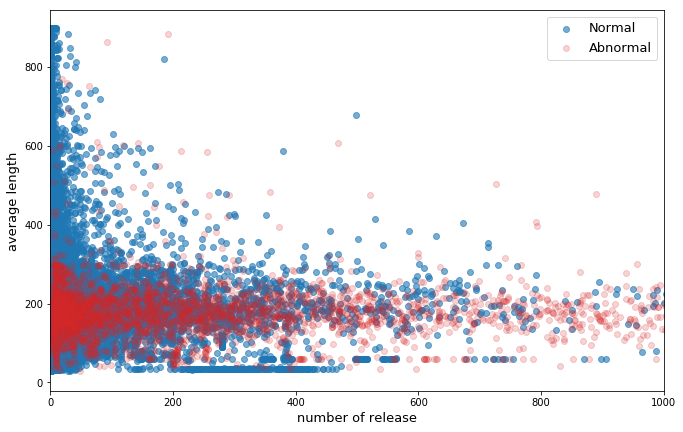

In [60]:
plt.figure(figsize=(11, 7))
plt.scatter(x=track_dist['time'].drop(fraud), y=track_dist['mean_len'].drop(fraud), color=colors[0], 
            alpha=.6, label='Normal')
plt.scatter(x=track_dist['time'].loc[fraud], y=track_dist['mean_len'].loc[fraud], color=colors[3], 
            alpha=.2, label='Abnormal')
plt.xlabel('number of release', size=13)
plt.ylabel('average length', size=13)
plt.xlim((0, 1000))
plt.legend(prop={'size': 13})

plt.show()

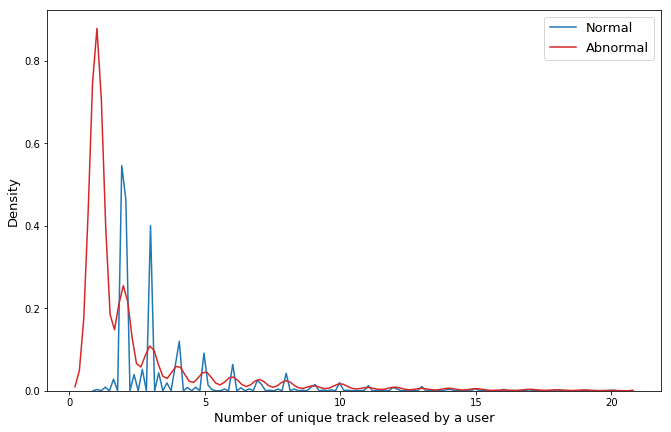

In [42]:
fraud = data.loc[data>3]
fraud.name = 'cnt'
fraud = fraud.reset_index()
fraud = fraud['user_id'].unique()

# Plot delta distribution
plt.figure(figsize=(11, 7))
sns.distplot(user_track.drop(fraud).loc[user_track<=20], hist=False, color=colors[0], label='Normal')
sns.distplot(user_track.loc[fraud].loc[user_track<=20], hist=False, color=colors[3], label='Abnormal')
plt.xlabel('Number of unique track released by a user', size=13)
plt.ylabel('Density', size=13)
plt.legend(prop={'size': 13})

plt.show()

# Abnomal Behavior 3:  huge amount of release
## Rules :  ueser release exceed 11 times in same period 
describe: there is elbow in below chart, 11 is a turining point 

In [41]:
release_time_user = streams.groupby(['user_id','timestamp']).size()

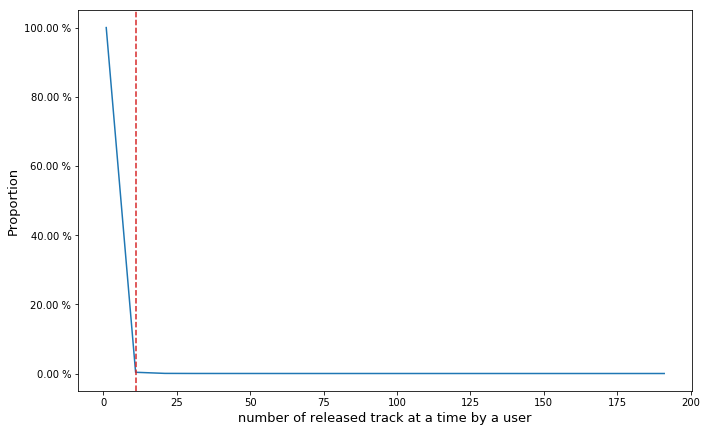

In [53]:
from matplotlib.ticker import FuncFormatter

def dis_percent(x, pos):
    return '%1.2f %%' %(x * 100)

prop = len(release_time_user)
x = np.arange(1, 200, 10)
y = [len(release_time_user.loc[release_time_user>=i])/prop for i in x]


fig, ax = plt.subplots(figsize=(11, 7))
formatter = FuncFormatter(dis_percent)
ax.yaxis.set_major_formatter(formatter)
plt.plot(x, y)
plt.axvline(x=11, color=colors[3], linestyle='dashed')
plt.xlabel('number of released track at a time by a user', fontsize=13)
plt.ylabel('Proportion', fontsize=13)

plt.show()

# Discussion

## 1. Would it automately segment the big size of release when the duration of release exceed 900 sec?
ex : same track release several time and been released at continuous peiord (like 08:30 and 08:45)

In [31]:
release.loc[(streams['track_id']=='d23e6c7bdef19e7a223a95c6e3ab6177671037fa') & 
            (streams['user_id']=='9a052dec69a62f6ade87ae7fb7ed5ce344c0f047')].head(10)

,device_type,length,os,timestamp,track_id,user_id,delta
1247,mobile,900,iOS,2017-09-09 00:00:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,NaN
4652,mobile,202,iOS,2017-09-09 00:00:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1160773,tablet,400,iOS,2017-09-09 08:30:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,30600.0
1180417,tablet,202,iOS,2017-09-09 08:45:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,900.0
1231519,tablet,202,iOS,2017-09-09 09:00:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1248030,tablet,501,iOS,2017-09-09 09:00:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1275677,tablet,397,iOS,2017-09-09 09:15:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1513651,mobile,345,iOS,2017-09-09 10:15:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1513697,mobile,213,iOS,2017-09-09 10:15:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1521253,mobile,202,iOS,2017-09-09 10:30:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,900.0


## 2. Is it a normal scenario that same tack been released by different users?
track_id = '2318538f5412b3e87cf335fb667c0e7f121ae830'   
released by 98 unique users

In [32]:
track_cnt = streams['track_id'].value_counts()

In [33]:
track_cnt.describe()

count     83426.000000
mean         51.705487
std        1251.849138
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max      232564.000000
Name: track_id, dtype: float64

In [35]:
track_top_index = track_cnt[track_cnt>10].index
track_top = streams.loc[streams['track_id'].isin(track_top_index)]

In [38]:
streams[streams['track_id']=='2318538f5412b3e87cf335fb667c0e7f121ae830']['user_id'].unique().shape

(98,)

In [40]:
streams[streams['track_id']=='2318538f5412b3e87cf335fb667c0e7f121ae830']['user_id'].unique()[:10]

array(['bab3607bf601e7e681012f206b62b4b39ee7023c',
       'ced586ba20b5c939afce663869ea6d2dbe100ae3',
       'd64bc4d547fa77a1df5490eeea205e2b96448744',
       '46ba44758a656c71af6fa8d61a1d82a8ebc24320',
       '435586b2ccecb215a907fce07b15f5959fa28fe0',
       '56e2506c1270e838cd401d7aa117dee8d7170514',
       '2f35b4e14a2eaddb04c30a5adf19010856387e0e',
       'b6e97cda7559fb309836f9d3142c8d8f97a3d4d5',
       '79311a85288b7f84dafab916a2975e2674a46a6f',
       '095d42c87e01748c1fecb23723c887ea6d8bc793'], dtype=object)